# Collaborative filtering KNN based recommendation systems examples

## Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('./src')

from scipy.spatial.distance import correlation, cosine

from ratings_matrix import RatingsMatrix
from dataset import MovielensDataset

from similarity import cosine_sim, \
                       pearson_sim, \
                       spearman_sim, \
                       adjusted_cosine_sim, \
                       spearman

from predictor import PredictorFactory, \
                      predict

from evaluator import Evaluator

from metric import RootMeanSquaredErrorMetric, \
                   MeanSquaredErrorMetric, \
                   PrecisionKMetric, \
                   RecallMetric, \
                   AVGPrecisionMetric, \
                   PrecisionMetric, \
                   FBetaKMetric

from similarity import CommonSimilarityService, \
                       AdjustedCosineSimilarityService

from show import show_similar_items, \
                 show_similar_users, \
                 show_prediction

from util import group_by, \
                 most_common

## User-Item Ratings Matrix

* [Ratings matrix](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/ratings_matrix.py) is a user-item ratings matrix where ratings are integers between 1 and 10.
* 6 users (rows) have rated 6 items (columns).

In [3]:
rm = RatingsMatrix([
    [3, 7, 4, 9,  9, 7], 
    [7, 0, 5, 3,  8, 8],
    [7, 5, 5, 0,  8, 4],
    [5, 6, 8, 5,  9, 8],
    [5, 8, 8, 8, 10, 9],
    [7, 7, 0, 4,  7, 8]
])
rm.shape

(6, 6)

User ratings / row values:

In [4]:
rm.row(1)

array([[3, 7, 4, 9, 9, 7]])

Mean user rating / row mean:

$\overline{Row}_i = \frac{1}{C}  \sum_{j=0}^{C-1} Value_{i, j}$

* $i$ is a row.
* $j$ is a column.
* $C$ is columns size.

In [5]:
rm.mean_row(1)

6.5

User rating deviance:

$Deviance_{i, j} = Value_{i, j} - \overline{Row}_i$

* $i$ is a row.
* $j$ is a column.

In [6]:
rm.row_deviation(1, 1)

-3.5

User(Row)-item(Column) rating:

In [7]:
rm.cell(3, 4)

0

Iterate each rating:

In [8]:
[f'rating: {r}, user_id: {u_id}, item_id: {i_id}' for r, u_id, i_id in rm.cells][:5]

['rating: 3, user_id: 1, item_id: 1',
 'rating: 7, user_id: 1, item_id: 2',
 'rating: 4, user_id: 1, item_id: 3',
 'rating: 9, user_id: 1, item_id: 4',
 'rating: 9, user_id: 1, item_id: 5']

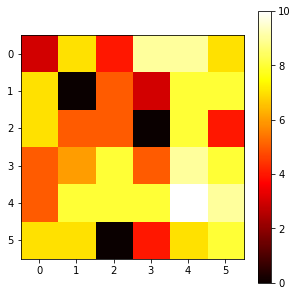

In [9]:
rm.plot()

## Users similarity

In [10]:
cosine_sim(rm)

,0,1,2,3,4,5
0,1.000000,0.799268,0.779227,0.934622,0.973890,0.884600
1,0.799268,1.000000,0.874744,0.905850,0.866146,0.827036
2,0.779227,0.874744,1.000000,0.909513,0.865454,0.853275
3,0.934622,0.905850,0.909513,1.000000,0.989344,0.865614
4,0.973890,0.866146,0.865454,0.989344,1.000000,0.881640
5,0.884600,0.827036,0.853275,0.865614,0.881640,1.000000


In [11]:
adjusted_cosine_sim(rm)

,0,1,2,3,4,5
0,1.000000,0.236908,0.421263,-0.519085,-0.125892,0.010090
1,0.236908,1.000000,-0.805243,0.085741,0.237273,0.520625
2,0.421263,-0.805243,1.000000,-0.767941,-0.230521,-0.053640
3,-0.519085,0.085741,-0.767941,1.000000,-0.299059,-0.644550
4,-0.125892,0.237273,-0.230521,-0.299059,1.000000,0.599158
5,0.010090,0.520625,-0.053640,-0.644550,0.599158,1.000000


## User based recomendation system using cosine similarity

### Similar users

[CommonSimilarityService](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/similarity/service/impl/common_similarity_service.py) class finds k similar users give a _user id_. in this case we use cosine similarity:


<center>$\Large cosine \mspace{3mu} distance_{a, b} = \frac{ \sum_{j \in C} r_{a, j}.r_{b, j}}{\sqrt{\sum_{j \in C} r_{a, j}^2}.\sqrt{\sum_{j \in C} r_{b, j}^2}  }$</center>



<center>$\Large cosine \mspace{3mu} similarity_{a, b} = 1 - cosine \mspace{3mu} distance_{a, b}$</center>



#### Observations

* $C$ is columns count in [Ratings matrix](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/ratings_matrix.py).
* $j$ is a column number.
* $a$ and $b$ are two rows in [Ratings matrix](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/ratings_matrix.py) 
of which we want to know how similar they are.
* $a$ and $b$ represent ratings of both users for all items (one for column).
* $ 0 <= cosine \mspace{3mu} similarity_{a, b} <= 1$. The higher the value the more similar.

In [12]:
n_neighbors = 4
user_id     = 1

predictor_factory = PredictorFactory()

sim_service = CommonSimilarityService(rm, cosine, n_neighbors)

similarities, indices = sim_service.similars(user_id)

show_similar_users(indices, similarities, user_id)

4 most similar users to user 1:

- User ID 5, with similarity of 0.9738899354018394.
- User ID 4, with similarity of 0.9346216841783769.
- User ID 6, with similarity of 0.8846004572297814.
- User ID 2, with similarity of 0.7992679780524188.


### User based predictor

[UserBasedPredictor](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/predictor/impl/user_based_predictor.py) class predicts ratings for specified user-item combinations based on user-based approach. Predictions are computed as weighted average of deviations from neighbor’s mean and adding it to active user’s mean rating.

<center>$\Large prediction_{u, i} = \overline{r}_u + \frac{\sum_{o \in K} (r_{o, i} - \overline{r}_o) . w_{u, o} }{ \sum_{o \in K} w_{u, o}}, u \neq o $</center>

#### Observations

* We seek to predict the rating than user $u$ gave to item $i$ calculating $prediction_{u, i}$.
* $o$ (other) user belongs to $K$, the set of all users similar to $u$ user.
* $w_{u,o}$ is the similarity between users $u$ and $o$ ($w_{u,o} = similarity_{u,o} = 1 - distance_{u,o}$).
* $K$ could be calculated using any subclass of [SimilarityService](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/similarity/service/similarity_service.py) ([CommonSimilarityService](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/similarity/service/impl/common_similarity_service.py) or [AdjustedCosineSimilarityService](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/similarity/service/impl/adjusted_cosine_similarity_service.py)).
* $\overline{r}_{u}$ is the mean of all ratings made by $u$ user.
* $r_{o,i} - \overline{r}_{o}$ is the diference between the $o$ user rating to $i$ item and $\overline{r}_{o}$ mean. Is used to adjust the user associated biases. User biases occur as certain users may tend to always give high or low ratings to all items.

In [13]:
evaluator = Evaluator(
    metrics=[
        MeanSquaredErrorMetric(decimals=4),
        RootMeanSquaredErrorMetric(decimals=4),
        PrecisionKMetric(k=5, decimals=4),
        PrecisionKMetric(k=10, decimals=4),
        PrecisionKMetric(k=30, decimals=4),
        FBetaKMetric(k=5,  beta=.5, decimals=4),
        FBetaKMetric(k=10, beta=.5, decimals=4),
        FBetaKMetric(k=30, beta=.5, decimals=4),
        FBetaKMetric(k=5,  beta=1, decimals=4),
        FBetaKMetric(k=10, beta=1, decimals=4),
        FBetaKMetric(k=30, beta=1, decimals=4),
        FBetaKMetric(k=5,  beta=1.5, decimals=4),
        FBetaKMetric(k=10, beta=1.5, decimals=4),
        FBetaKMetric(k=30, beta=1.5, decimals=4),
        PrecisionMetric(decimals=4),
        RecallMetric(decimals=4)
        # AVGPrecisionMetric(decimals=4),
    ]
)

In [14]:
predictor = predictor_factory.create('knn_cosine_user_based', rm, n_neighbors)

evaluator.evaluate(predictors=[predictor], rm=rm, transpose=True)

Predictor,knn_cosine_user_based
MSE,2.8928
RMSE,1.7008
Precision@5,0.3750
Precision@10,0.4286
Precision@30,0.2574
F0.5Score@5,0.2000
F0.5Score@10,0.2143
F0.5Score@30,0.3537
F1Score@5,0.0000
F1Score@10,0.2143


In [15]:
user_id = 3
item_id = 4

show_prediction(rm, user_id, item_id, predictor.predict(user_id, item_id))

Item base rating prediction:
- User ID: 3.
- Item ID: 4.
- Predicted rating: 3.450903595941009.
- Real rating: 0 (0 == unrated item).


In [16]:
user_id = 1
item_id = 5

show_prediction(rm, user_id, item_id, predictor.predict(user_id, item_id))

Item base rating prediction:
- User ID: 1.
- Item ID: 5.
- Predicted rating: 8.60564770282165.
- Real rating: 9 (0 == unrated item).


## Item based recommedation system using cosine similarity

### Similar items

[CommonSimilarityService](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/similarity/service/impl/common_similarity_service.py) class finds k similar items given the _item_id_ and a transposed version of ratings matrix.

In [17]:
item_id = 3

sim_service = CommonSimilarityService(rm.T(), cosine, n_neighbors)

similarities, indices = sim_service.similars(item_id)

show_similar_items(indices, similarities, item_id)

4 most similar items to item 3:

- Item ID 5, with similarity of 0.9183361255345218.
- Item ID 6, with similarity of 0.874759773038195.
- Item ID 1, with similarity of 0.8103647462221735.
- Item ID 4, with similarity of 0.7969178003023931.


### Item based predict

In this approach, similarities between pair of items are computed using $cosine \mspace{3mu} similarity \mspace{3mu}$ ($1 - cosine \mspace{3mu} distance$). The rating for target item $i$ for active user $a$ can be predicted by using a simple weighted average as:

<center>$\Large prediction_{u, i} = \frac{\sum_{j \in K} r_{u, j}. w_{i, j} }{\sum_{j \in K} w_{i, j} }, i \neq j $</center>

#### Observations

* We seek to predict the rating than user $u$  gave to item $i$ calculating $prediction_{u,i}$.
* $K$ is the neighborhood of $j$ items most similar to $i$ item. $j$ belongs to $K$ and $i \neq j$. 
* $w_{i,j}$ is the similarity between items $i$ and $j$ ($w_{i,j}$ = $similarity_{i,j} = 1 - distance_{i,j}$).

In [18]:
predictor = predictor_factory.create('knn_cosine_item_based', rm, n_neighbors)

In [19]:
evaluator.evaluate(predictors=[predictor], rm=rm, transpose=True)

Predictor,knn_cosine_item_based
MSE,3.2925
RMSE,1.8145
Precision@5,0.0000
Precision@10,0.0833
Precision@30,0.0903
F0.5Score@5,0.3750
F0.5Score@10,0.1389
F0.5Score@30,0.1052
F1Score@5,0.1000
F1Score@10,0.2778


In [20]:
user_id = 4
item_id = 3

show_prediction(rm, user_id, item_id, predictor.predict(user_id, item_id))

Item base rating prediction:
- User ID: 4.
- Item ID: 3.
- Predicted rating: 7.742467352632247.
- Real rating: 8 (0 == unrated item).


## Item based recommedation system using adjusted cosine similarity

### Similar items

Using cosine similarity metric for item-based CF approach **does not consider difference in ratings of users**. Adjusted cosine similarity offsets this drawback by subtracting respective user’s average rating ($\overline{r}_u$) from each co-rated pair, and is defined as below:

<center>$\Large adj. \mspace{3mu} cosine \mspace{3mu} distance_{i, j} = \frac{ \sum_{u \in U} (r_{u, i} - \overline{r}_{u}).(r_{u, j} - \overline{r}_{u})}{\sqrt{ \sum_{u \in U} (r_{u, i} - \overline{r}_{u})^2}.\sqrt{ \sum_{u \in U} (r_{u, j} - \overline{r}_{u})^2}}$</center>



<center>$\Large adj. \mspace{3mu} cosine \mspace{3mu} similarity_{i, j} = 1 - adj. \mspace{3mu} cosine \mspace{3mu} distance_{i, i}$</center>

#### Observations

* $U$ all users in [Ratings matrix](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/ratings_matrix.py).
* $u$ a given user.
* $i$ and $j$ represent two items.

[AdjustedCosineSimilarityService](https://github.com/adrianmarino/cf-rec-sys-examples/blob/master/src/similarity/service/impl/adjusted_cosine_similarity_service.py) class finds k similar items given the _item_id_ and ratings matrix.

In [21]:
user_id = 3 

sim_service = AdjustedCosineSimilarityService(rm, n_neighbors)

similarities, indices = sim_service.similars(item_id)

show_similar_items(indices, similarities, item_id)

4 most similar items to item 3:

- Item ID 1, with similarity of 0.42126273187113467.
- Item ID 6, with similarity of -0.05363989048891138.
- Item ID 5, with similarity of -0.2305213582693748.
- Item ID 4, with similarity of -0.7679410465751941.


### Item based predictor

In [22]:
predictor = predictor_factory.create('knn_adj_cosine_item_based', rm, n_neighbors)
evaluator.evaluate(predictors=[predictor], rm=rm, transpose=True)

Predictor,knn_adj_cosine_item_based
MSE,13.2281
RMSE,3.6370
Precision@5,0.2857
Precision@10,0.0667
Precision@30,0.2824
F0.5Score@5,0.3750
F0.5Score@10,0.1389
F0.5Score@30,0.2421
F1Score@5,0.0833
F1Score@10,0.3125


In [23]:
user_id = 1
item_id = 1

show_prediction(rm, user_id, item_id, predictor.predict(user_id, item_id))

Item base rating prediction:
- User ID: 1.
- Item ID: 1.
- Predicted rating: 4.205640412693527.
- Real rating: 3 (0 == unrated item).


## Predict and evaluate

Evaluate all recomendation systems with distinct dsitance measures under example rating matrix.

In [24]:
%%time
predictors = predictor_factory.create_all(rm, n_neighbors)

CPU times: user 3.76 ms, sys: 43 ms, total: 46.8 ms
Wall time: 64.3 ms


In [25]:
user_id=1
item_id=5

print('True rating:', rm.cell(user_id, item_id))
predict(predictors, user_id, item_id)

True rating: 9


,Prediction
Predictor,
knn_cosine_user_based,8.61
knn_cosine_item_based,6.84
knn_pearson_user_based,8.30
knn_pearson_item_based,0.00
knn_adj_cosine_item_based,9.49
knn_euclidean_user_based,0.00
knn_euclidean_item_based,0.00
knn_minkowski_user_based,0.00
knn_minkowski_item_based,0.00


if the item is already rated, it is not recommended:

In [26]:
user_id=2
item_id=1

print('True rating:', rm.cell(user_id, item_id))
predict(predictors, user_id, item_id)

True rating: 7


,Prediction
Predictor,
knn_cosine_user_based,4.84
knn_cosine_item_based,6.50
knn_pearson_user_based,5.19
knn_pearson_item_based,5.37
knn_adj_cosine_item_based,3.86
knn_euclidean_user_based,0.00
knn_euclidean_item_based,0.00
knn_minkowski_user_based,0.00
knn_minkowski_item_based,0.00


Evaluate predictions using _RMSE_ and _MAE_ error metrics:

In [27]:
evaluator.evaluate(predictors, rm) \
    .sort_values(by='Precision@5', ascending=False) \
    .style.hide(axis='index')

Predictor,MSE,RMSE,Precision@5,Precision@10,Precision@30,F0.5Score@5,F0.5Score@10,F0.5Score@30,F1Score@5,F1Score@10,F1Score@30,F1.5Score@5,F1.5Score@10,F1.5Score@30,Precision,Recall
knn_cosine_item_based,3.292500,1.814500,0.100000,0.071400,0.111100,0.000000,0.100000,0.107100,0.133300,0.055600,0.107100,0.166700,0.047600,0.113100,0.105200,0.093800
knn_pearson_user_based,1.867200,1.366500,0.083300,0.361100,0.323100,0.250000,0.261900,0.284400,0.125000,0.500000,0.353700,0.200000,0.402800,0.281400,0.302600,0.389300
knn_pearson_item_based,11.622700,3.409200,0.083300,0.186700,0.119800,0.333300,0.041700,0.096300,0.200000,0.125000,0.085700,0.166700,0.216700,0.128000,0.096100,0.079600
knn_cosine_user_based,2.892800,1.700800,0.066700,0.190500,0.175000,0.300000,0.023800,0.175600,0.142900,0.266700,0.281200,0.166700,0.071400,0.275000,0.288700,0.326400
knn_adj_cosine_item_based,13.228100,3.637000,0.000000,0.291700,0.251300,0.166700,0.107100,0.256000,0.300000,0.250000,0.259300,0.250000,0.190500,0.256000,0.251300,0.261900
knn_euclidean_user_based,48.333300,6.952200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
knn_euclidean_item_based,48.333300,6.952200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
knn_minkowski_user_based,48.333300,6.952200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
knn_minkowski_item_based,48.333300,6.952200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
knn_mahalanobis_user_based,48.333300,6.952200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Using Movie Lens dataset

### User-Item Ratings Matrix

In [28]:
%%time
dataset = MovielensDataset(n_users=300, n_movies=300)
rating_table = dataset.ratings()

group_by(rating_table, 'rating').T

CPU times: user 24.4 ms, sys: 9.27 ms, total: 33.7 ms
Wall time: 33.4 ms


,0,1,2,3,4,5,6,7,8,9
rating,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
count,229.0,456.0,244.0,1226.0,1049.0,4346.0,3448.0,7815.0,2930.0,4858.0


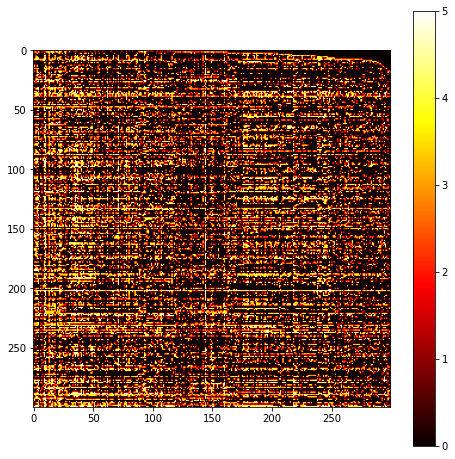

Size: (300, 300)
CPU times: user 600 ms, sys: 3.16 ms, total: 603 ms
Wall time: 604 ms


In [29]:
%%time
rm = RatingsMatrix.from_df(rating_table, rows='user_seq', columns='movie_seq', value='rating')

rm.plot((8, 8))
print(f'Size: {rm.shape}')

## Evaluate all recomendations system combinations

In [30]:
user_id = most_common(rating_table, 'user_seq',  limit=20)[-1]
item_id = most_common(rating_table, 'movie_seq', limit=20)[-1]

In [31]:
%%time
predictors = predictor_factory.create_all(rm, n_neighbors=20)

CPU times: user 37.2 ms, sys: 57.3 ms, total: 94.5 ms
Wall time: 6min 9s


In [32]:
%%time
print('True rating:', rm.cell(user_id, item_id))
predict(predictors, user_id, item_id)

True rating: 3.5
CPU times: user 17.2 ms, sys: 49.1 ms, total: 66.3 ms
Wall time: 98.4 ms


,Prediction
Predictor,
knn_cosine_user_based,3.87
knn_cosine_item_based,4.28
knn_pearson_user_based,4.40
knn_pearson_item_based,3.86
knn_adj_cosine_item_based,3.96
knn_euclidean_user_based,0.00
knn_euclidean_item_based,0.00
knn_minkowski_user_based,0.00
knn_minkowski_item_based,0.00


In [33]:
%%time
evaluator.evaluate(predictors, rm) \
    .sort_values(by='Precision@5', ascending=False) \
    .style.hide(axis='index')

CPU times: user 3.64 s, sys: 91.6 ms, total: 3.73 s
Wall time: 3min 58s


Predictor,MSE,RMSE,Precision@5,Precision@10,Precision@30,F0.5Score@5,F0.5Score@10,F0.5Score@30,F1Score@5,F1Score@10,F1Score@30,F1.5Score@5,F1.5Score@10,F1.5Score@30,Precision,Recall
knn_cosine_user_based,1.571500,1.253600,0.666700,0.400000,0.390100,0.125000,0.225000,0.050000,0.000000,0.285700,0.107400,0.333300,0.160700,0.284500,0.183200,0.203100
knn_adj_cosine_item_based,0.570500,0.755300,0.666700,0.283300,0.456800,0.125000,0.750000,0.406200,1.000000,0.333300,0.408600,0.250000,0.600000,0.285700,0.318300,0.420000
knn_chebyshev_item_based,15.025600,3.876300,0.333300,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166700,0.000000,0.000000,0.000000,0.166700,0.001400
knn_cosine_item_based,1.750900,1.323200,0.125000,0.150000,0.155600,0.500000,0.291700,0.194400,0.333300,0.259300,0.283300,0.333300,0.250000,0.129600,0.210400,0.243200
knn_pearson_item_based,2.233400,1.494400,0.100000,0.366700,0.144100,0.250000,0.358300,0.190500,0.125000,0.512500,0.175000,0.375000,0.342900,0.289500,0.226000,0.242800
knn_pearson_user_based,1.061800,1.030400,0.000000,0.208300,0.216700,0.444400,0.166700,0.242900,0.166700,0.125000,0.175600,0.500000,0.100000,0.162500,0.167000,0.191600
knn_euclidean_user_based,15.025600,3.876300,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.500000,0.166700,0.200000,0.000000,0.000000,0.000000,0.166700,0.001400
knn_euclidean_item_based,15.025600,3.876300,0.000000,0.000000,0.000000,0.333300,0.000000,0.000000,0.000000,0.250000,0.166700,0.000000,0.000000,0.000000,0.166700,0.001400
knn_minkowski_user_based,15.025600,3.876300,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166700,0.001400
knn_minkowski_item_based,15.025600,3.876300,0.000000,0.000000,0.200000,0.000000,0.000000,0.166700,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.166700,0.001400
